Single LSTM

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [123]:
# Load the rainfall data
data = pd.read_csv('Cherranpunji Rainfall.csv')

In [125]:
data.head()

,YEAR,DOY,QV2M,RH2M,PRECTOTCORR,T2M_MAX,T2M_MIN,T2MWET,T2MDEW,WD10M,WS10M_MAX,WS10M_MIN
0,1981,5,5.98,70.75,0.23,15.79,5.10,7.01,4.31,249.00,3.18,1.05
1,1981,6,7.20,83.94,0.14,14.13,5.39,8.34,6.99,242.56,3.68,1.25
2,1981,7,7.87,87.94,6.24,14.34,7.80,9.39,8.37,154.44,3.38,0.49
3,1981,8,7.20,86.06,3.23,14.59,6.51,8.38,7.15,202.19,3.26,0.38
4,1981,9,6.23,83.44,0.01,14.44,2.52,6.42,5.05,59.62,2.49,0.86


In [126]:
# Extract the rainfall values
rainfall_values = data['PRECTOTCORR'].values

In [127]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_values.reshape(-1, 1))


In [128]:
# Define the sequence length and number of features
sequence_length = 13
n_features = 1

In [129]:
# Create sequences and labels
sequences = []
labels = []
for i in range(sequence_length, len(scaled_data)):
    sequences.append(scaled_data[i-sequence_length:i, 0])
    labels.append(scaled_data[i, 0])

In [130]:
# Convert sequences and labels to NumPy arrays
sequences = np.array(sequences)
labels = np.array(labels)

In [131]:
# Reshape sequences for LSTM input
sequences = np.reshape(sequences, (sequences.shape[0], sequence_length, n_features))

In [132]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))

In [133]:
train_sequences = sequences[:split_index]
train_labels = labels[:split_index]
test_sequences = sequences[split_index:]
test_labels = labels[split_index:]

In [134]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(LSTM(50))
model.add(Dense(1))


In [135]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [136]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [137]:
# Train the model and store the training history
history = model.fit(train_sequences, train_labels, epochs=100, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

Epoch 1/100
368/368 [==============================] - 6s 9ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 2/100
368/368 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 3/100
368/368 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 4/100
368/368 [==============================] - 3s 8ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 5/100
368/368 [==============================] - 3s 8ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 6/100
368/368 [==============================] - 3s 8ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 7/100
368/368 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 8/100
368/368 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 9/100
368/368 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 10/100
368/368 [==============================] - 3s 8ms/step - loss: 0.0014 - val_lo

In [138]:
# Make predictions
predicted_labels = model.predict(test_sequences)

92/92 [==============================] - 1s 3ms/step


In [139]:
# Inverse transform the predicted and actual labels
predicted_labels = scaler.inverse_transform(predicted_labels)
test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1))


In [140]:
# Calculate evaluation metrics
mae = np.mean(np.abs(predicted_labels - test_labels))
rmse = np.sqrt(np.mean(np.square(predicted_labels - test_labels)))
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Square Error (RMSE):', rmse)


Mean Absolute Error (MAE): 6.971134404280633
Root Mean Square Error (RMSE): 14.446870177514127


In [142]:
# Extract training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

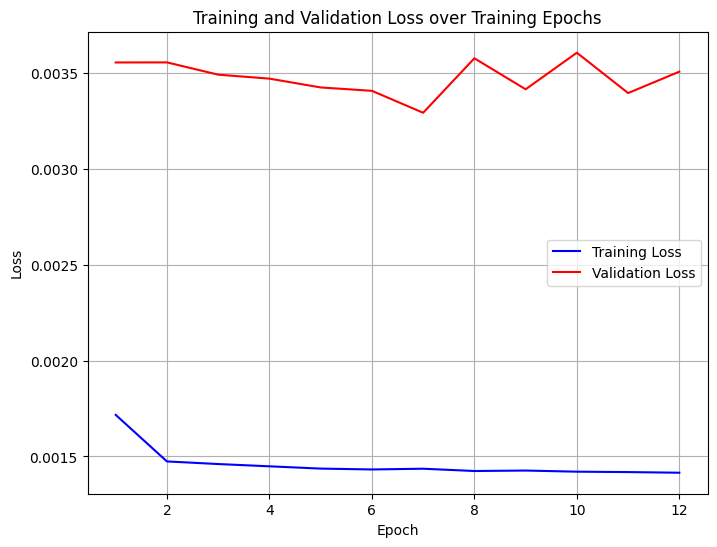

In [143]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [144]:
# Define the threshold for rainfall prediction
threshold = 0.5

In [145]:
# Convert predicted labels to binary values based on the threshold
binary_predicted_labels = (predicted_labels > threshold).astype(int)


In [146]:
# Calculate the percentage of rainfall predictions
prediction_percentage = np.mean(binary_predicted_labels) * 100

print("Rainfall Prediction Percentage: {:.2f}%".format(prediction_percentage))

Rainfall Prediction Percentage: 65.30%
